In [1]:
import copy

import numpy as np
from scipy.io import loadmat, savemat
#import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

import dataholders as dh
import utils

In [2]:
def get_multipoint_fit(data, part):

    #data = copy.deepcopy(data)
    
    time_uft = data['time_av'].ravel()
    lowV = data['lowV_av'].ravel()
    upV = data['upV_av'].ravel()

    uft_vars = [lowV, upV]

    T_virtual = data['sonicT'].ravel()
    water = data['licorH2O'].ravel()

    T_ref = T_virtual / (1 + 0.61 * water * 1e-3)
    
    actos_vars = [T_ref]
    
    time_actos = np.arange(T_virtual.shape[0]) / 100. #data['time'].ravel()

    time, uft_sync, actos_sync = utils.synchronize(time_uft, time_actos, uft_vars, actos_vars)
    [lowV, upV] = uft_sync
    [T_ref] = actos_sync
    
    lowV = utils.array_range(lowV, *part, ref=time)
    upV = utils.array_range(upV, *part, ref=time)
    
    T_ref = utils.array_range(T_ref, *part, ref=time)
    
    #print(lowV.shape, upV.shape, T_ref.shape)
    #print(time[-1])
    
    popt1, _ = curve_fit(lambda x, a, b: a*x + b, lowV, T_ref)
    popt2, _ = curve_fit(lambda x, a, b: a*x + b, upV, T_ref)
    
    return popt1, popt2

In [3]:
path = 'data/data_flight16.mat'
data = loadmat(path)
#data.cut_time(*flat1)

In [4]:
popts_low = []
popts_up  = []
time = []

LEN = 1000
STEP = 10

for start in tqdm(range(0, 6950, STEP)):
    popt1, popt2 = get_multipoint_fit(data, (start, start + LEN))
    time.append(start)
    popts_low.append(popt1)
    popts_up.append(popt2)

time = np.array(time)
popts_low = np.stack(popts_low)
popts_up = np.stack(popts_up)

100%|████████████████████████████████████████████████████████████████████████████████| 695/695 [02:01<00:00,  5.73it/s]


In [5]:
popts_low_cut = np.vstack((
    utils.array_range(popts_low, 200, 951, time),
    utils.array_range(popts_low, 3800, 6901, time)))

In [6]:
popts_up_cut = np.vstack((
    utils.array_range(popts_up, 200, 951, time),
    utils.array_range(popts_up, 3800, 6901, time)))

In [7]:
popts_low_cut.mean(axis=0)

array([ 35.15711315, -84.03851989])

In [8]:
popts_up_cut.mean(0)

array([ 36.42433892, -79.6217585 ])

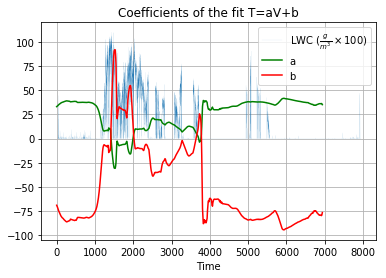

In [40]:
plt.plot(data['time_av'], 100*data['lwc1V_av'], lw=.05)

plt.plot(time, popts_up[:,0], c='g')
plt.plot(time, popts_up[:,1], c='r')
plt.grid(True)
plt.title("Coefficients of the fit T=aV+b")
plt.xlabel("Time")



plt.legend([r'LWC ($\frac{g}{m^3}\times 100$)', 'a', 'b', ])
plt.savefig('report/up_fits.eps', format='eps')
plt.show()

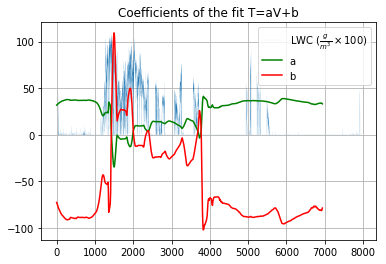

In [41]:
plt.plot(data['time_av'], 100*data['lwc1V_av'], lw=.05)


plt.plot(time, popts_low[:,0], c='g')
plt.plot(time, popts_low[:,1], c='r')
plt.grid(True)
plt.title("Coefficients of the fit T=aV+b")


plt.legend([r'LWC ($\frac{g}{m^3}\times 100$)', 'a', 'b', ])
plt.savefig('report/low_fits.eps', format='eps')
plt.show()

In [19]:
lowT_fits = np.array([
    [45.11, -112.98],
    [37.45, -91.11],
    [37., -89.75],
    [37.17, -89.12],
    [35.3, -84.16],
    [32.49, -75.78],
    [35.16, -84.04],
])

upT_fits = np.array([
    [46.51, -106.66],
    [39.37, -87.87],
    [40.34, -90.58],
    [39.46, -87.07],
    [38.18, -84.03],
    [33.42, -70.97],
    [36.42, -79.62],
])

In [20]:
lowT_fits.shape

(7, 2)

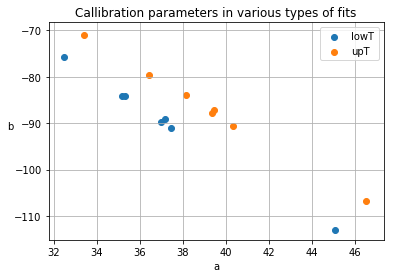

In [38]:
plt.scatter(lowT_fits[:,0], lowT_fits[:,1])
plt.scatter(upT_fits[:,0], upT_fits[:,1])

plt.legend(['lowT', 'upT'])

plt.grid(True)
plt.title("Callibration parameters in various types of fits")

plt.xlabel("a")
plt.ylabel("b", rotation=0)

plt.savefig('report/fits_scatter.eps', format='eps')
plt.show()

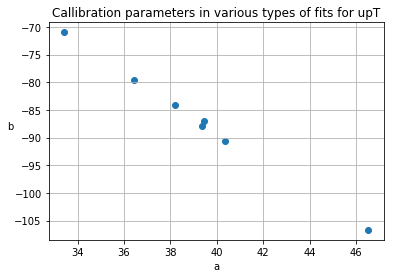

In [28]:
plt.scatter(upT_fits[:,0], upT_fits[:,1])
plt.grid(True)
plt.title("Callibration parameters in various types of fits for upT")

plt.xlabel("a")
plt.ylabel("b", rotation=0)

plt.savefig('report/up_fits_scatter.eps', format='eps')
plt.show()